In [14]:
import pandas as pd
import numpy as np
import os
import string
import math
from time import localtime, strftime
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import decomposition
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
def write_csv(ID, Price, filename=""):
    result = pd.DataFrame(columns = ["Id", "SalePrice"])
    result["Id"] = ID
    result["SalePrice"] = Price
    if filename == "":
        filename = "Result_" + strftime("%Y%m%d%H%M", localtime())
    filename = filename + ".csv"
    result.to_csv(os.path.join("./Result/", filename), sep=",", index=False)
    return result

def plot_scatter(x, y, c=3):
    number_feature = []
    for fea, typ in zip(data.columns, data.dtypes):
        if typ == "int64" or typ == "float64":
            number_feature.append(fea)
    nrows = len(number_feature) // c
    ncols = c
    for i, fea in enumerate(number_feature):
        plt.subplot(nrows, ncols, i+1)
        plt.scatter(x[fea], y)
        plt.title(fea)
    plt.show()

In [16]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)

data_dir = "./Data/"

train_data = pd.read_csv(os.path.join(data_dir, "train.csv"))
test = pd.read_csv(os.path.join(data_dir,"test.csv"))
train_Y = train_data['SalePrice']
train = train_data.drop(["Id", "SalePrice"], axis=1)
test_id = test["Id"]
test = test.drop(["Id"], axis=1)
data = pd.concat([train, test])

train_num = train.shape[0]
test_num = test.shape[0]
print(data.shape)
print(data.describe())
print(data.isna().sum().sort_values(ascending=False))
print(train.dtypes)

(2919, 79)
        MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  2919.000000  2433.000000    2919.000000  2919.000000  2919.000000   
mean     57.137718    69.305795   10168.114080     6.089072     5.564577   
std      42.517628    23.344905    7886.996359     1.409947     1.113131   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    59.000000    7478.000000     5.000000     5.000000   
50%      50.000000    68.000000    9453.000000     6.000000     5.000000   
75%      70.000000    80.000000   11570.000000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  \
count  2919.000000   2919.000000  2896.000000  2918.000000  2918.000000   
mean   1971.312778   1984.264474   102.201312   441.423235    49.582248   
std      30.291442     20.894344   179.334253   455.610826   169.205611   
min 

C:\Users\Hsin-PC\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


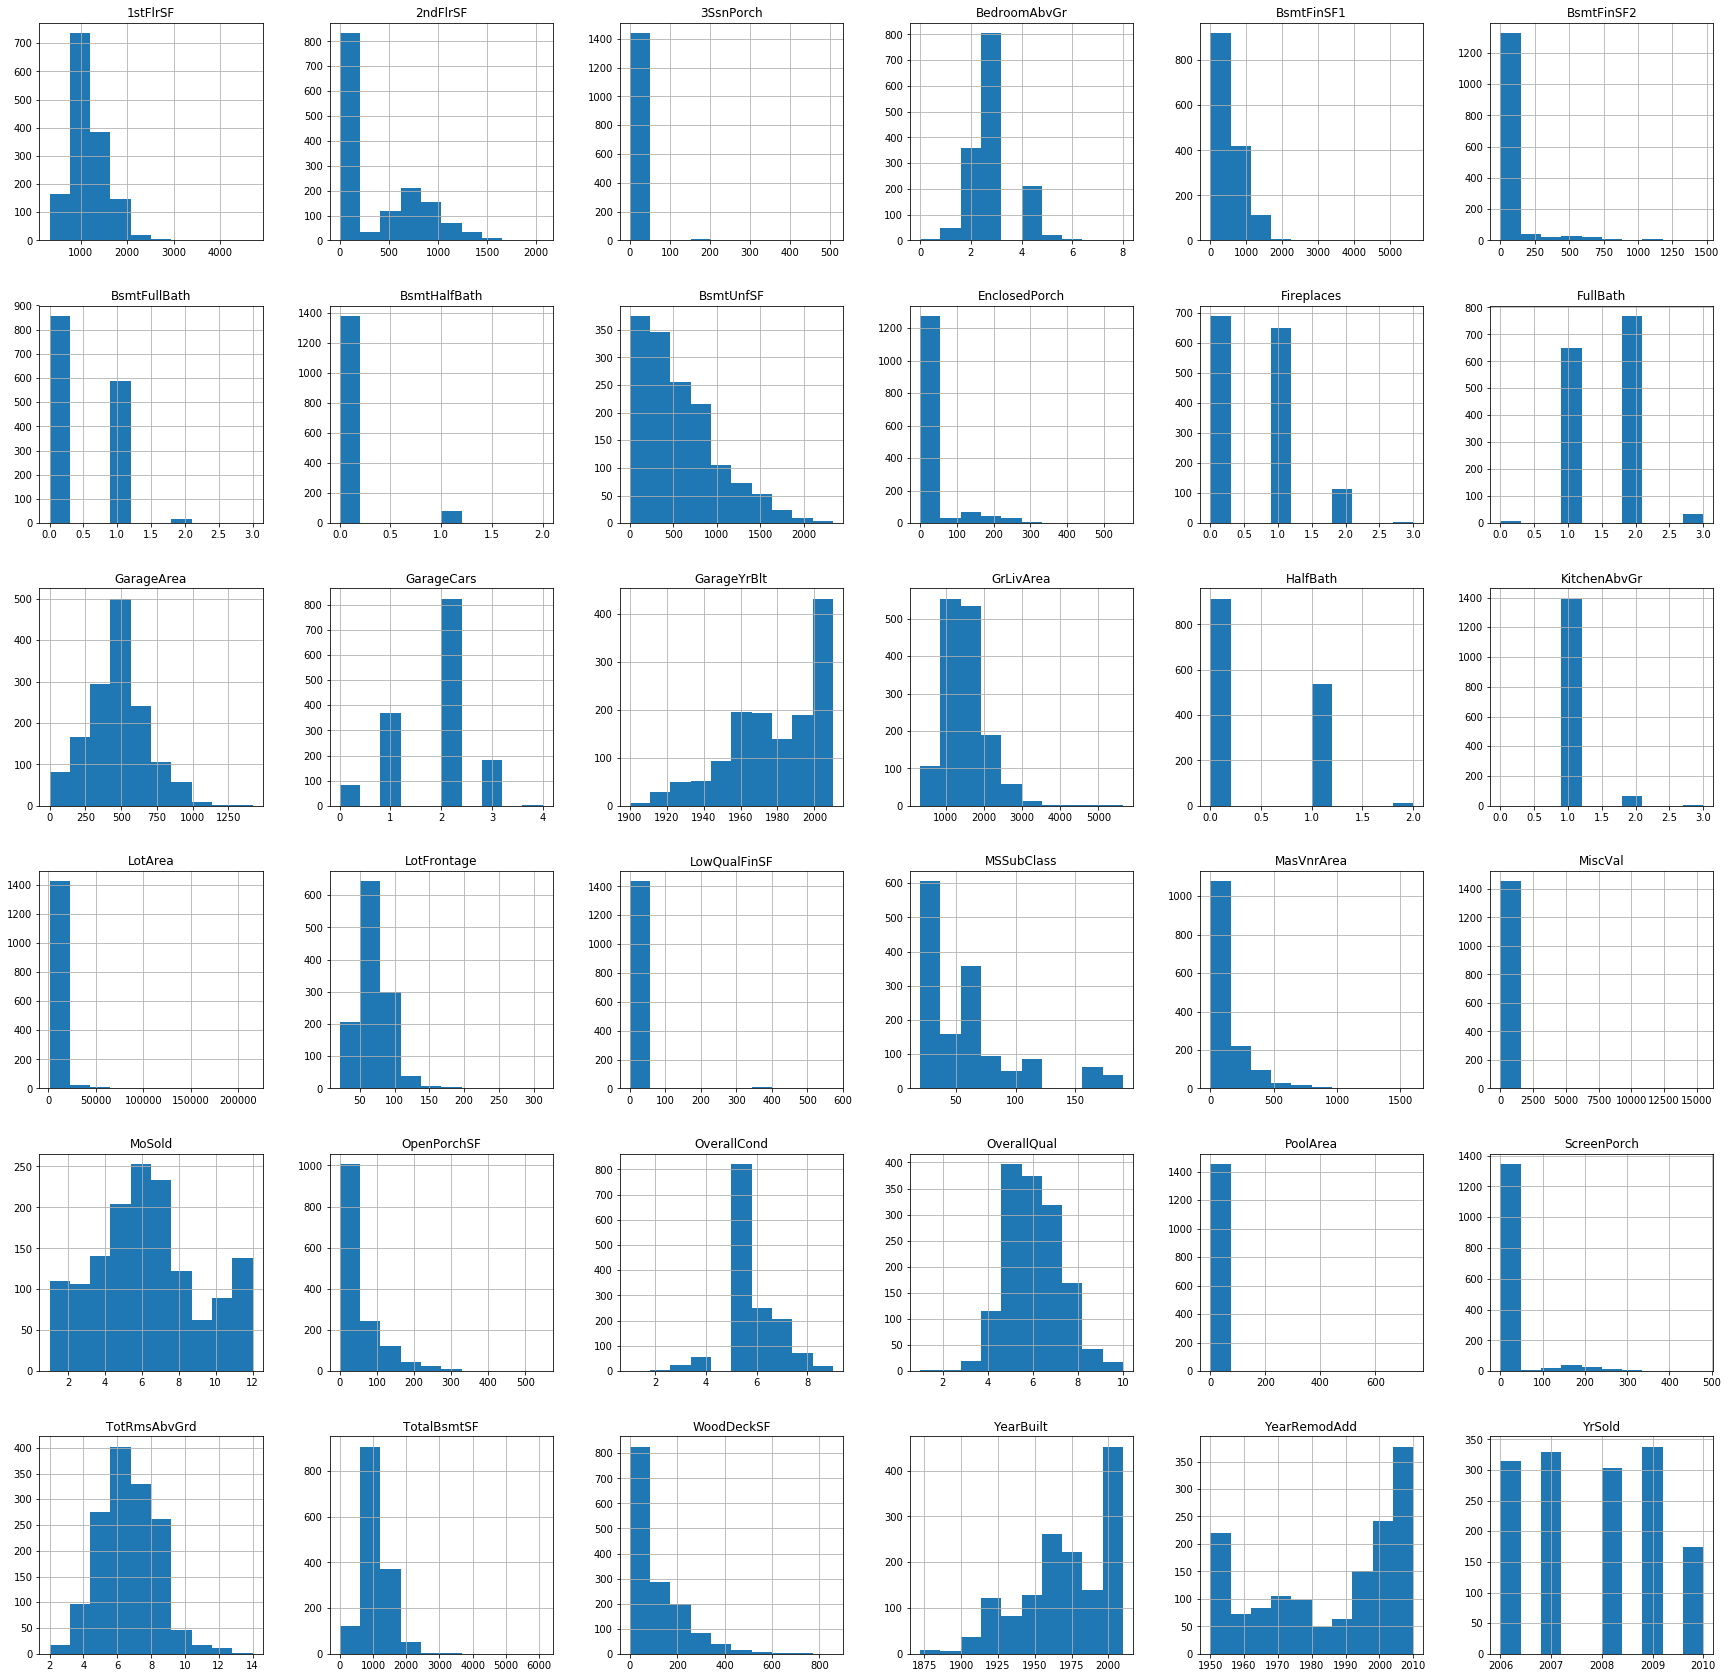

In [17]:
fig = plt.figure(figsize = (30,30))
ax = fig.gca()
train.hist(ax = ax)
plt.show()

In [18]:
data['MSSubClass'] = data['MSSubClass'].apply(str)
number_feature = []
object_feature = []
for fea, typ in zip(data.columns, data.dtypes):
    if typ == "int64" or typ == "float64":
        number_feature.append(fea)
    if typ == "object":
        object_feature.append(fea)
print("Number_Feature:%i, Object_Feature:%i" %(len(number_feature), len(object_feature)))
print(number_feature)
data.info()

Number_Feature:35, Object_Feature:44
['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 79 columns):
MSSubClass       2919 non-null object
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-nu

# 缺失值填補

In [19]:
def Missing_Replace(data, fea_array, replace="None"):
    for fea in fea_array:
        if replace == "Mean":
            data[fea] = data[fea].fillna(data[fea].mean())
        elif replace == "Mode":
            data[fea] = data[fea].fillna(str(data[fea].mode()[0]))
        elif replace == "Max":
            data[fea] = data[fea].fillna(data[fea].max())
        else:
            data[fea] = data[fea].fillna(replace)
    return data

Missing_None = ["MasVnrType", "BsmtQual", "BsmtCond", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", 
                "GarageFinish", "GarageCond", "GarageQual", "PoolQC", "Fence", "MiscFeature", "Alley", "Utilities"]
Missing_0 = ["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "2ndFlrSF",
             "LowQualFinSF", "GrLivArea", "BsmtFullBath", "BsmtHalfBath", "GarageCars", "GarageArea", "GarageYrBlt"]
Missing_Mean = ["1stFlrSF"]
Missing_Mode = ["MSZoning", "Exterior1st", "Exterior2nd", "Foundation", "BsmtExposure", "Electrical", 
                "KitchenQual", "Functional", "SaleType"]
data_dp = data.copy()
data_dp = Missing_Replace(data_dp, Missing_None, replace="None")
data_dp = Missing_Replace(data_dp, Missing_0, replace=0)
data_dp = Missing_Replace(data_dp, Missing_Mean, replace="Mean")
data_dp = Missing_Replace(data_dp, Missing_Mode, replace="Mode")
print(data_dp.isna().sum().sort_values(ascending=False).head(10))

SaleCondition    0
Foundation       0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
BsmtQual         0
dtype: int64


In [20]:
#plt.figure(figsize=(30,30))
#plot_scatter(train, train_Y, 4)

# Feature Engineering

C:\Users\Hsin-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64


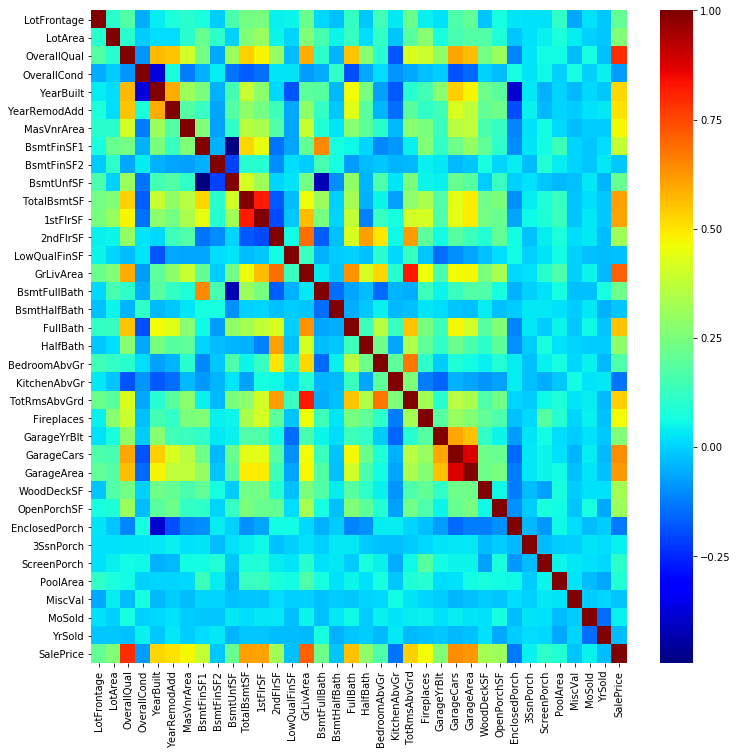

In [22]:
train_dp = data_dp.iloc[:train_num, :]
train_dp["SalePrice"] = train_Y
temp_corr = train_dp.corr()
plt.figure(figsize = (12, 12))
print(abs(temp_corr["SalePrice"]).sort_values(ascending=False).head(10))
sns.heatmap(temp_corr, cmap="jet", annot = False)

In [23]:
#去除偏態，把面積資料都取Log
LogTranf_columns = ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", 
                    "LowQualFinSF", "GrLivArea", "GarageArea"]
for fea in LogTranf_columns:
    data_dp[fea] = np.log(data_dp[fea] + 1)

In [25]:
#OneHot_columns = ["MSZoning"]
#Label_columns = [x for x in object_feature if x not in OneHot_columns]
Label_columns = ['MSSubClass']
OneHot_columns = [x for x in object_feature if x not in Label_columns]
data_dp = pd.get_dummies(data_dp, columns=OneHot_columns)

for fea in Label_columns:
    data_dp[fea] = LabelEncoder().fit_transform(data_dp[fea])
print(data_dp.head(5))

   MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          10         65.0     8450            7            5       2003   
1           5         80.0     9600            6            8       1976   
2          10         68.0    11250            7            5       2001   
3          11         60.0     9550            7            5       1915   
4          10         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          2003       196.0    6.561031         0.0   5.017280     6.753438   
1          1976         0.0    6.886532         0.0   5.652489     7.141245   
2          2002       162.0    6.188264         0.0   6.075346     6.825460   
3          1970         0.0    5.379897         0.0   6.293419     6.629363   
4          2000       350.0    6.486161         0.0   6.196444     7.044033   

   1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHa

In [26]:
MeanGroup_columns = ["OverallQual", "GarageCars"]
data_fe = data_dp.copy()
for fea in MeanGroup_columns:
    MeanGroup_data = train_dp.groupby(fea)["SalePrice"].mean().reset_index()
    MeanGroup_data.columns = [fea, f"{fea}_Mean"]
    data_fe = pd.merge(data_fe, MeanGroup_data, on=fea, how='left')
    data_fe = data_fe.drop([fea], axis=1)
print(data_fe.isna().sum().sort_values(ascending=False).head(10))
data_fe = Missing_Replace(data_fe, ["GarageCars_Mean"], replace="Max")
#print(data_dp.shape)
#print(data_fe.shape)

GarageCars_Mean      1
Condition1_RRAn      0
Condition1_RRNn      0
Condition2_Artery    0
Condition2_Feedr     0
Condition2_Norm      0
Condition2_PosA      0
Condition2_PosN      0
Condition2_RRAe      0
Condition2_RRAn      0
dtype: int64
GarageCars_Mean      0
Condition1_RRAn      0
Condition1_RRNn      0
Condition2_Artery    0
Condition2_Feedr     0
Condition2_Norm      0
Condition2_PosA      0
Condition2_PosN      0
Condition2_RRAe      0
Condition2_RRAn      0
dtype: int64


In [27]:
#data_scaler = StandardScaler().fit_transform(data_fe)
data_scaler = MinMaxScaler().fit_transform(data_fe)
data_scaler = pd.DataFrame(data_scaler)
print(data_scaler.shape)

print(data_fe.isna().sum().sort_values(ascending=False).head(10))

(2919, 302)
GarageCars_Mean      0
Condition1_RRAn      0
Condition1_RRNn      0
Condition2_Artery    0
Condition2_Feedr     0
Condition2_Norm      0
Condition2_PosA      0
Condition2_PosN      0
Condition2_RRAe      0
Condition2_RRAn      0
dtype: int64


C:\Users\Hsin-PC\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [28]:
pca = decomposition.PCA(n_components=50)
pca.fit(data_dp)
data_pca = pca.transform(data_scaler)
data_pca = pd.DataFrame(data_pca)
print(data_pca.shape)
print(type(data_pca))
print(pca.explained_variance_ratio_) 
print(pca.explained_variance_)

(2919, 50)
<class 'pandas.core.frame.DataFrame'>
[9.90686389e-01 5.10511989e-03 3.21633998e-03 5.04578536e-04
 2.37713049e-04 7.34909235e-05 6.39242735e-05 4.90574593e-05
 2.03953566e-05 1.63339868e-05 1.21584805e-05 1.00701563e-05
 3.36794236e-06 3.00279862e-07 1.40751769e-07 1.18140209e-07
 9.55946320e-08 6.44069792e-08 4.74628260e-08 2.73102411e-08
 2.65331559e-08 1.72486086e-08 1.50285029e-08 9.59978649e-09
 9.27331928e-09 7.74737803e-09 6.85042330e-09 6.79066231e-09
 6.29053681e-09 5.46660617e-09 4.84616220e-09 4.76861102e-09
 4.54417673e-09 4.45710790e-09 4.28780387e-09 4.03896110e-09
 3.82254078e-09 3.78532636e-09 3.58044901e-09 3.43466965e-09
 3.41341782e-09 3.21459236e-09 3.17300023e-09 3.00811976e-09
 2.95018842e-09 2.87558824e-09 2.84601854e-09 2.79599082e-09
 2.53888400e-09 2.46883635e-09]
[6.22083503e+07 3.20566720e+05 2.01964220e+05 3.16840916e+04
 1.49267586e+04 4.61472890e+03 4.01400851e+03 3.08047395e+03
 1.28068933e+03 1.02566300e+03 7.63469675e+02 6.32337151e+02
 2.1

In [29]:
#train_X = data_fe.iloc[:train_num,:]
#test_x = data_fe.iloc[(train_num):,:]
train_X = data_scaler.iloc[:train_num,:]
test_x = data_scaler.iloc[(train_num):,:]
#train_X = data_pca.iloc[:train_num,:]
#test_x = data_pca.iloc[(train_num):,:]
print(train_X.shape, print(train_num))
print(test_x.shape, print(test_num))

1460
(1460, 302) None
1459
(1459, 302) None


In [31]:
train_Y = np.log1p(train_Y)
x_train, x_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.2, random_state=727)

In [33]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
rmse_train_reg = math.sqrt(mse(y_train, lr_reg.predict(x_train)))
rmse_valid_reg = math.sqrt(mse(y_valid, lr_reg.predict(x_valid)))
print("Train_RMSE: %.6f" %rmse_train_reg)
print("Valid_RMSE: %.6f" %rmse_valid_reg)
y_pred_reg = lr_reg.predict(test_x)
output = write_csv(test_id, np.expm1(y_pred_reg), "reg_v6")

Train_RMSE: 0.087343
Valid_RMSE: 2227357161.449405


C:\Users\Hsin-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in expm1
  


In [34]:
lasso_reg = Lasso(alpha = 1)
lasso_reg.fit(x_train, y_train)
rmse_train_lasso = math.sqrt(mse(y_train, lasso_reg.predict(x_train)))
rmse_valid_lasso = math.sqrt(mse(y_valid, lasso_reg.predict(x_valid)))
print("Train_RMSE: %.6f" %rmse_train_lasso)
print("Valid_RMSE: %.6f" %rmse_valid_lasso)
y_pred_lasso = lasso_reg.predict(test_x)
#output = write_csv(test_id, np.expm1(y_pred_lasso), "lasso_v3")

Train_RMSE: 0.400931
Valid_RMSE: 0.392800


In [35]:
lasso_reg = Lasso(alpha = 1)
lasso_reg.fit(x_train, y_train)
rmse_train_lasso = math.sqrt(mse(y_train, lasso_reg.predict(x_train)))
rmse_valid_lasso = math.sqrt(mse(y_valid, lasso_reg.predict(x_valid)))
print("Train_RMSE: %.6f" %rmse_train_lasso)
print("Valid_RMSE: %.6f" %rmse_valid_lasso)
y_pred_lasso = lasso_reg.predict(test_x)
#output = write_csv(test_id, np.expm1(y_pred_lasso), "lasso_v3")

Train_RMSE: 0.400931
Valid_RMSE: 0.392800


In [36]:
ridge_reg = Ridge(alpha = 1)
ridge_reg.fit(x_train, y_train)
rmse_train_ridge = math.sqrt(mse(y_train, ridge_reg.predict(x_train)))
rmse_valid_ridge = math.sqrt(mse(y_valid, ridge_reg.predict(x_valid)))
print("Train_RMSE: %.6f" %rmse_train_ridge)
print("Valid_RMSE: %.6f" %rmse_valid_ridge)
y_pred_ridge = ridge_reg.predict(test_x)
output = write_csv(test_id, np.expm1(y_pred_ridge), "ridge_v5")

Train_RMSE: 0.093975
Valid_RMSE: 0.129111


In [37]:
alpha_list = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
l1_list = [0.01, 0.1, 0.2, 0.4, 0.5, 0.7, 0.9, 0.99]

In [38]:
ridgecv_reg = RidgeCV(alphas = alpha_list )
ridgecv_reg.fit(x_train, y_train)
rmse_train_ridgecv = math.sqrt(mse(y_train, ridgecv_reg.predict(x_train)))
rmse_valid_ridgecv = math.sqrt(mse(y_valid, ridgecv_reg.predict(x_valid)))
print("Train_RMSE: %.6f" %rmse_train_ridgecv)
print("Valid_RMSE: %.6f" %rmse_valid_ridgecv)
print(ridgecv_reg.alpha_)
y_pred_ridgecv = ridgecv_reg.predict(test_x)
output = write_csv(test_id, np.expm1(y_pred_ridgecv), "ridgecv_v6")

Train_RMSE: 0.093975
Valid_RMSE: 0.129111
1.0


In [41]:
elastic_reg = ElasticNetCV(alphas = alpha_list , l1_ratio = l1_list, max_iter=10000, cv=10)
elastic_reg.fit(x_train, y_train)
rmse_train_elastic = math.sqrt(mse(y_train, elastic_reg.predict(x_train)))
rmse_valid_elastic = math.sqrt(mse(y_valid, elastic_reg.predict(x_valid)))
print("Train_RMSE: %.6f" %rmse_train_elastic)
print("Valid_RMSE: %.6f" %rmse_valid_elastic)
print(elastic_reg.alpha_, elastic_reg.l1_ratio_)
y_pred_elastic = elastic_reg.predict(test_x)
output = write_csv(test_id, np.expm1(y_pred_elastic), "elasticCV_Advance_v1")

Train_RMSE: 0.106764
Valid_RMSE: 0.119914
0.001 0.5


In [40]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear')
xg_reg.fit(x_train, y_train)
rmse_train_xg = math.sqrt(mse(y_train, xg_reg.predict(x_train)))
rmse_valid_xg = math.sqrt(mse(y_valid, xg_reg.predict(x_valid)))
print("Train_RMSE: %.6f" %rmse_train_xg)
print("Valid_RMSE: %.6f" %rmse_valid_xg)
y_pred_xg = xg_reg.predict(test_x)
output = write_csv(test_id, np.expm1(y_pred_xg), "xgb_v6")

[00:18:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Hsin-PC\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Train_RMSE: 0.084430
Valid_RMSE: 0.137215


In [214]:
rf_reg = RandomForestRegressor(max_depth=10, n_estimators=30)
rf_reg.fit(x_train, y_train)
rmse_train_rf = math.sqrt(mse(y_train, rf_reg.predict(x_train)))
rmse_valid_rf = math.sqrt(mse(y_valid, rf_reg.predict(x_valid)))
print("Train_RMSE: %.6f" %rmse_train_rf)
print("Valid_RMSE: %.6f" %rmse_valid_rf)
y_pred_rf = rf_reg.predict(test_x)
#output = write_csv(test_ID, np.expm1(y_pred_rf), "rf_v1")

#rf_reg.importance

Train_RMSE: 0.066156
Valid_RMSE: 0.140640


In [215]:
def GridSearchResult(x, y, model, para, cv=5):
    parasearch = GridSearchCV(model , param_grid = para, scoring='neg_mean_squared_error', cv=cv)
    parasearch.fit(x,y)
    print("Best_Parameter:", parasearch.best_params_)
    print("Best_Score:", parasearch.best_score_)
    return parasearch

In [216]:
rf_reg_grid = RandomForestRegressor()
param = {
    "max_depth": range(2, 11, 2),
    "n_estimators": range(10, 51, 10)
}
rf_reg_grid = GridSearchResult(x_train, y_train, rf_reg_grid, param, 3)
rmse_train_rf_grid = math.sqrt(mse(y_train, rf_reg_grid.predict(x_train)))
rmse_valid_rf_grid = math.sqrt(mse(y_valid, rf_reg_grid.predict(x_valid)))
print("Train_RMSE: %.6f" %rmse_train_rf_grid)
print("Valid_RMSE: %.6f" %rmse_valid_rf_grid)

Best_Parameter: {'max_depth': 10, 'n_estimators': 50}
Best_Score: -0.023448218774168757
Train_RMSE: 0.060523
Valid_RMSE: 0.137169


In [217]:
print(rf_reg.feature_importances_)

[1.77271633e-03 4.06858320e-03 1.41280372e-02 1.95749197e-04
 4.73657159e-04 1.91437746e-03 1.77861979e-03 0.00000000e+00
 4.07443247e-04 6.92157070e-04 4.96902524e-03 3.45330465e-04
 1.28900087e-04 3.72562613e-04 1.10771470e-03 9.98591975e-03
 2.20562427e-02 7.92486746e-03 7.12936727e-04 2.89437186e-04
 2.31013936e-03 1.69737579e-03 4.76016179e-04 2.29702518e-03
 2.91828085e-03 2.03104446e-03 9.05685946e-04 7.83870232e-03
 1.58715661e-03 1.57436866e-03 2.79428608e-03 2.07065611e-02
 4.72694798e-04 5.26865477e-04 5.71458470e-03 4.28933437e-02
 1.90613036e-04 1.22885209e-03 8.67921308e-03 1.00346865e-03
 2.66996818e-02 5.65623273e-03 1.95856631e-04 1.11045378e-01
 1.02701355e-03 6.99925073e-05 3.93275463e-03 5.32149022e-04
 1.21896025e-03 2.34080571e-03 2.56967782e-03 2.29572723e-03
 2.22848303e-03 4.45314502e-03 9.77735303e-04 1.21032263e-02
 7.37087901e-03 2.18471725e-03 1.77101986e-02 1.05572542e-03
 4.98281410e-04 8.30683995e-04 2.80171043e-03 3.95178578e-03
 1.46365056e-03 3.021088

In [218]:
new_X = pd.DataFrame()
new_X["lr_result"] = lr_reg.predict(train_X)
#new_X["lasso_result"] = lasso_reg.predict(train_X)
new_X["Ridge_result"] = ridge_reg.predict(train_X)
new_X["rf_result"] = rf_reg.predict(train_X)
new_X["elastic_result"] = elastic_reg.predict(train_X)

x_train2, x_valid2, y_train2, y_valid2 = train_test_split(new_X, train_Y, test_size=0.1, random_state=727)
xg_reg_stack = xgb.XGBRegressor(objective ='reg:linear')
xg_reg_stack.fit(x_train2, y_train2)
rmse_train_xg_stack = math.sqrt(mse(y_train2, xg_reg_stack.predict(x_train2)))
rmse_valid_xg_stack = math.sqrt(mse(y_valid2, xg_reg_stack.predict(x_valid2)))
print("Train_RMSE: %.6f" %rmse_train_xg_stack)
print("Valid_RMSE: %.6f" %rmse_valid_xg_stack)
#y_pred_xg_stack = xg_reg_stack.predict(test_x)
#output = write_csv(test_id, np.expm1(y_pred_xg), "xgb_v4")

[23:42:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train_RMSE: 0.062240
Valid_RMSE: 0.130362


C:\Users\Hsin-PC\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
